In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [7]:
data_path = 'data/ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)
        )
    ])
)

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
# Weights: (n_out, n_in, kernel_size, kernel_size)
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

# Output is one-half conv kernel's width smaller on each side (3 // 2 = 1)
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

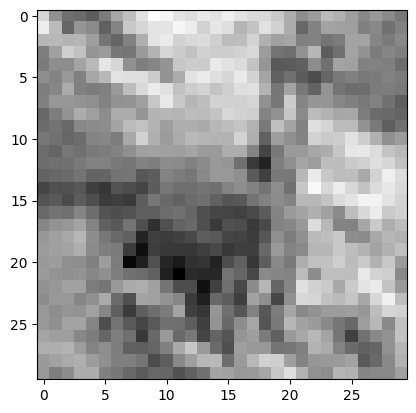

In [11]:
plt.imshow(output[0, 0].detach(), cmap='gray')

In [12]:
# Padding adds ghost pixels at the borders with value 0 so the size does not change
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

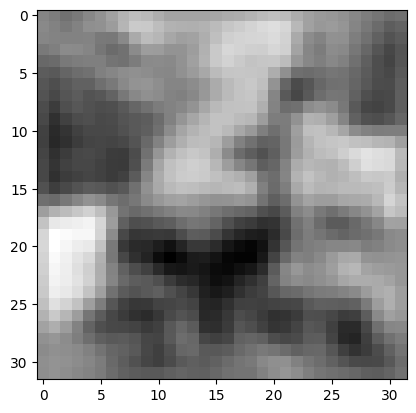

In [13]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

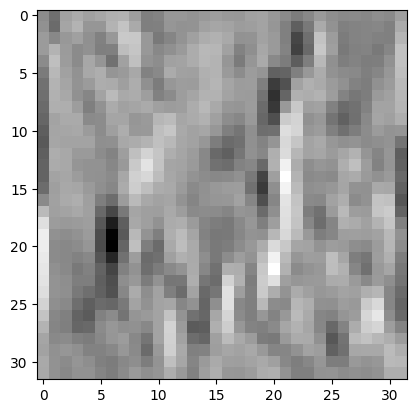

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

# For vertical edge detection: If pixels on the left and right differ a lot: high value
# Else they will be close to 0
with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

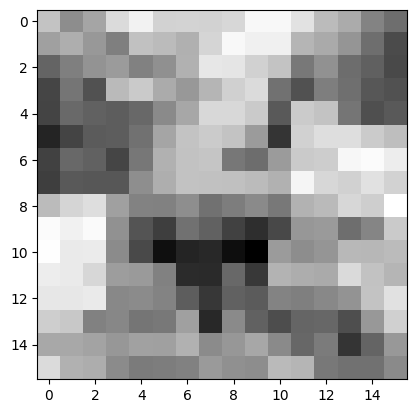

In [16]:
plt.imshow(output[0, 0].detach(), cmap='gray')

In [17]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...,
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [20]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [32]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)   # Reshape output
        out = torch.tanh(self.fc1(out))
        return self.fc2(out)

In [33]:
model = NeuralNet()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [35]:
model(img.unsqueeze(0)).detach().numpy()

array([[0.13001622, 0.18985581]], dtype=float32)

In [55]:
def training_loop(n_epochs, conv_model, optimizer, loss_fn, loader, device):
    for epoch in tqdm(range(1, n_epochs + 1)):
        epoch_loss = 0.0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = conv_model(images)
            train_loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_loss += train_loss.item()

        if epoch % 10 == 0 or epoch == 1:
            print(f'{datetime.datetime.now()} Epoch {epoch}: Loss {epoch_loss / len(loader)}')

In [56]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [57]:
c_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Training on device {c_device}.')

model = NeuralNet()
model = model.to(c_device)

optimizer_sgd = optim.SGD(model.parameters(), 1e-2)
loss = nn.CrossEntropyLoss()

training_loop(100, model, optimizer_sgd, loss, train_loader, c_device)

Training on device cuda.


  1%|          | 1/100 [00:00<00:38,  2.60it/s]

2025-07-16 15:46:57.685530 Epoch 1: Loss 0.5680093550757997


 10%|█         | 10/100 [00:03<00:28,  3.15it/s]

2025-07-16 15:47:00.628741 Epoch 10: Loss 0.3315935701511468


 20%|██        | 20/100 [00:06<00:29,  2.71it/s]

2025-07-16 15:47:04.119774 Epoch 20: Loss 0.2918432737421838


 30%|███       | 30/100 [00:10<00:23,  2.92it/s]

2025-07-16 15:47:07.399091 Epoch 30: Loss 0.2690503067651372


 40%|████      | 40/100 [00:13<00:22,  2.66it/s]

2025-07-16 15:47:11.041116 Epoch 40: Loss 0.2494759494142168


 50%|█████     | 50/100 [00:17<00:19,  2.56it/s]

2025-07-16 15:47:14.901298 Epoch 50: Loss 0.23207955000696667


 60%|██████    | 60/100 [00:21<00:14,  2.69it/s]

2025-07-16 15:47:18.362372 Epoch 60: Loss 0.21672460232760496


 70%|███████   | 70/100 [00:24<00:10,  2.93it/s]

2025-07-16 15:47:21.946807 Epoch 70: Loss 0.20162836628355038


 80%|████████  | 80/100 [00:27<00:06,  3.05it/s]

2025-07-16 15:47:25.226329 Epoch 80: Loss 0.18893818794542058


 90%|█████████ | 90/100 [00:31<00:03,  3.08it/s]

2025-07-16 15:47:28.490105 Epoch 90: Loss 0.17570551774304383


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]

2025-07-16 15:47:31.758315 Epoch 100: Loss 0.1630260386522029


In [58]:
def evaluate(conv_model, train_dloader, val_dloader, device):
    for name, loader in [('train', train_dloader), ('eval', val_dloader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = conv_model(images)
                _, predicted = outputs.max(dim=1)
                total += labels.shape[0]

                correct_batch = predicted == labels
                correct += int(correct_batch.sum())

        print(f'Accuracy {name}: {correct / total:.2f}')

In [59]:
evaluate(model, train_loader, val_loader, c_device)

Accuracy train: 0.94
Accuracy eval: 0.90


In [60]:
# Save model
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [61]:
loaded_model = NeuralNet().to(c_device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)   # Reshape output
        out = torch.tanh(self.fc1(out))
        return self.fc2(out)

In [63]:
# Manual weight decay
def training_loop_wd(n_epochs, conv_model, optimizer, loss_fn, loader, device):
    for epoch in tqdm(range(1, n_epochs + 1)):
        epoch_loss = 0.0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = conv_model(images)
            train_loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in conv_model.parameters())
            train_loss = train_loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_loss += train_loss.item()

        if epoch % 10 == 0 or epoch == 1:
            print(f'{datetime.datetime.now()} Epoch {epoch}: Loss {epoch_loss / len(loader)}')

# Or using pytorch
optimizer_decay = optim.SGD(model.parameters(), 1e-2, weight_decay=0.001)

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv_dropout1 = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv_dropout2 = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv_dropout1(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv_dropout2(out)
        out = out.view(-1, 16 * 8 * 8)   # Reshape output
        out = torch.tanh(self.fc1(out))
        return self.fc2(out)

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_channels1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_channels1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1_batchnorm(self.conv1(x))), 2)
        out = F.max_pool2d(torch.tanh(self.conv2_batchnorm(self.conv2(out))), 2)
        out = out.view(-1, 16 * 8 * 8)   # Reshape output
        out = torch.tanh(self.fc1(out))
        return self.fc2(out)

In [64]:
class NetDepth(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_channels1 // 2, n_channels1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)

        # Skip Connection
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)

        out = out.view(-1, 16 * 8 * 8)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

## Network from Building Blocks

In [70]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_channels)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)


    def forward(self, x):
        out = self.batch_norm(self.conv(x))
        return torch.relu(out) + x

In [90]:
class NetResDeep(nn.Module):
    def __init__(self, n_channels=32, n_blocks=10, kernel_size=3):
        super().__init__()

        self.n_channels = n_channels
        self.conv2d = nn.Conv2d(3, n_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.res_blocks = nn.Sequential(
            * (n_blocks * [ResBlock(n_channels)])
        )

        self.linear1 = nn.Linear(n_channels * 64, 32)
        self.linear2 = nn.Linear(32, 2)

    def forward(self, x):
        out = torch.max_pool2d(torch.relu(self.conv2d(x)), 2)
        out = self.res_blocks(out)
        out = torch.max_pool2d(out, 2)
        out = out.view(-1, self.n_channels * 64)
        out = torch.relu(self.linear1(out))
        return self.linear2(out)

In [75]:
resnet_model = NetResDeep(n_channels=32, n_blocks=10).to(device=c_device)
optimizer_sgd = optim.SGD(resnet_model.parameters(), lr=3e-3)
loss = nn.CrossEntropyLoss()

# def training_loop(n_epochs, conv_model, optimizer, loss_fn, loader, device):
training_loop(
    n_epochs = 100,
    conv_model = resnet_model,
    optimizer = optimizer_sgd,
    loss_fn = loss,
    loader = train_loader,
    device = c_device
)
evaluate(model, train_loader, val_loader, c_device)

  1%|          | 1/100 [00:02<04:00,  2.42s/it]

2025-07-16 16:38:33.744711 Epoch 1: Loss 0.5722927396084853


 10%|█         | 10/100 [00:25<03:54,  2.61s/it]

2025-07-16 16:38:56.870352 Epoch 10: Loss 0.34564479853317237


 20%|██        | 20/100 [00:51<03:29,  2.62s/it]

2025-07-16 16:39:23.093606 Epoch 20: Loss 0.25808324603138455


 30%|███       | 30/100 [01:17<03:01,  2.60s/it]

2025-07-16 16:39:49.130390 Epoch 30: Loss 0.19478124066902575


 40%|████      | 40/100 [01:43<02:35,  2.60s/it]

2025-07-16 16:40:15.116124 Epoch 40: Loss 0.14383493534698608


 50%|█████     | 50/100 [02:09<02:09,  2.60s/it]

2025-07-16 16:40:41.118017 Epoch 50: Loss 0.11431231458855283


 60%|██████    | 60/100 [02:35<01:43,  2.59s/it]

2025-07-16 16:41:07.143767 Epoch 60: Loss 0.10460384683624195


 70%|███████   | 70/100 [03:01<01:17,  2.60s/it]

2025-07-16 16:41:33.157053 Epoch 70: Loss 0.09695885553481473


 80%|████████  | 80/100 [03:27<00:51,  2.60s/it]

2025-07-16 16:41:59.157034 Epoch 80: Loss 0.09418934839925948


 90%|█████████ | 90/100 [03:53<00:25,  2.59s/it]

2025-07-16 16:42:25.065093 Epoch 90: Loss 0.10908287915454548


100%|██████████| 100/100 [04:19<00:00,  2.60s/it]

2025-07-16 16:42:51.013222 Epoch 100: Loss 0.09380998258378095
Accuracy train: 0.94
Accuracy eval: 0.90


## Exercises

### Exercise 1

Change model to use a 5 x 5 kernel.

In [109]:
def training_loop(n_epochs, conv_model, optimizer, loss_fn, loader, device):
    with tqdm(range(1, n_epochs + 1), desc='Training') as t:
        for epoch in t:
            epoch_loss = 0.0
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = conv_model(images)
                train_loss = loss_fn(outputs, labels)
                epoch_loss += train_loss.item()

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
            t.set_postfix(loss=(epoch_loss / len(loader)))

def evaluate(conv_model, tr_loader, eval_loader, device):
    for stage, loader in [('train', tr_loader), ('eval', eval_loader)]:
        correct = 0.0
        total = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = conv_model(images)
                _, predictions = outputs.max(dim=1)

                batch_correct = (predictions == labels)
                correct += int(batch_correct.sum())
                total += labels.shape[0]

        print(f'Accuracy {stage}: {correct / total:.2f}')

In [101]:
c_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
resnet_model = NetResDeep(n_channels=32, n_blocks=10, kernel_size=5).to(device=c_device)

optimizer_sgd = optim.SGD(resnet_model.parameters(), 3e-3)
loss = nn.CrossEntropyLoss()

training_loop(100, resnet_model, optimizer_sgd, loss, train_loader, c_device)

Training: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it, loss=0.00244]


In [112]:
ks3_model = NetResDeep(n_channels=32, n_blocks=10, kernel_size=3)

ks3_numel_list = [p.numel() for p in ks3_model.parameters()]
ks5_numel_list = [p.numel() for p in resnet_model.parameters()]

sum(ks3_numel_list), sum(ks5_numel_list)

(75810, 77346)

a) The impact is quite small.

In [110]:
resnet_model.eval()
evaluate(resnet_model, train_loader, val_loader, c_device)

Accuracy train: 0.76
Accuracy eval: 0.76


b) Overfitting seems a lot better. The accuracies are the same.

d) For this kernel size, the model would take into account the following 2 pixels.

e) It would be possible to look at relationships between horizontal neighbors.